### Install Dependencies

In [6]:
!pip install torch --quiet --quiet
!pip install coba --quiet --quiet
!pip install scipy --quiet --quiet
!pip install numpy --quiet --quiet
!pip install matplotlib --quiet --quiet
!pip install transformers --quiet --quiet
!pip install xformers --quiet --quiet
!pip install einops --quiet --quiet

### Run Demo

In [15]:
import torch

#convert datasets to pytorch tensors
class Tensorize:
    def filter(self, interactions):
        for interaction in interactions:
            interaction['context'] = torch.tensor(interaction['context'])
            yield interaction

from AbstractClasses import RewardPredictor
from CauchyNetwork import CauchyNetwork
from typing import Sequence
from coba.primitives import Batch

class MyRewardPredictor(RewardPredictor):
    def __init__(self, *, numrff:int, sigma:float, in_features:int, opt_factory, sched_factory) -> None:
        self._cauchy_network = CauchyNetwork(numrff,sigma,in_features)
        self.loss            = torch.nn.BCEWithLogitsLoss(reduction='none')
        self.opt             = opt_factory(self._cauchy_network.parameters())
        self.scheduler       = sched_factory(self.opt)

    @property
    def params(self):
        return self._cauchy_network.params

    #one context many actions (add more documentation)
    def predict(self, context: torch.Tensor, actions: torch.Tensor) -> Sequence[float]:
        with torch.no_grad():
            X = torch.cat([context.unsqueeze(0).expand(actions.size()[0],-1),
                           actions.unsqueeze(1)],dim=1)
            return self._cauchy_network.reward(X)

    #these are triples in parallel arrays (TODO: cleanup documentation)
    def learn(self, 
              contexts: Sequence[torch.Tensor]|torch.Tensor,
              actions : Sequence[float]|float, 
              rewards : Sequence[float]|float) -> None:
        if isinstance(contexts,Batch):
            X = torch.cat([torch.stack(contexts),torch.tensor(actions).unsqueeze(1)],dim=1)
            y = torch.tensor(rewards)
        else:
            X = torch.cat([contexts,torch.tensor([actions])])
            y = torch.tensor([rewards])

        self.opt.zero_grad()
        pred = self._cauchy_network.pre_logits(X)
        loss = self.loss(pred.squeeze(1),y)
        loss.mean().backward()
        self.opt.step()
        self.scheduler.step()
    
        with torch.no_grad():
            cb.CobaContext.learning_info['reward_prediction_loss'] = loss.tolist()

class UniformReferencePolicy:
    def __init__(self, batch_size:int = 100):
        self._batch_size = batch_size

    def sample(self, context):
        while True:
            yield torch.rand(self._batch_size)

2023-07-18 16:39:59 -- Processing chunk...
2023-07-18 16:39:59 --   * Recording Learner 0 parameters... (0.0 seconds) (completed)
2023-07-18 16:39:59 --   * Recording Environment 0 statistics... (0.0 seconds) (completed)
2023-07-18 16:39:59 --   * Peeking at Environment 0... (0.18 seconds) (completed)
2023-07-18 16:40:54 --   * Evaluating Learner 0 on Environment 0... (54.34 seconds) (completed)


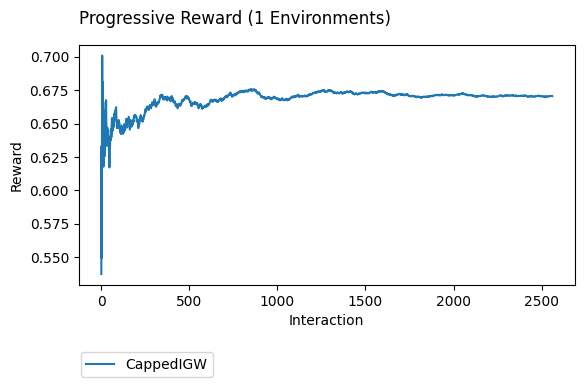

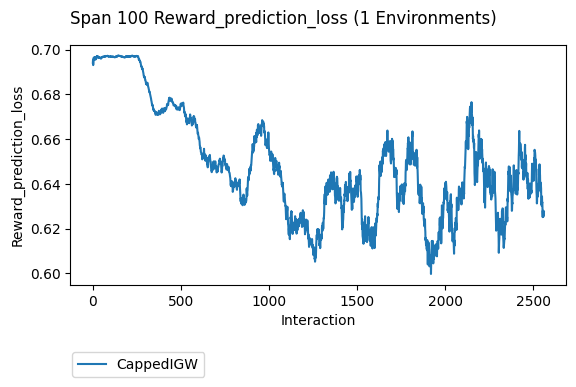

In [39]:
import numpy as np
from math import sqrt
import coba as cb
from CappedIGW import CappedIGW

#these values are specific to openml dataset 1187
n_context_dim, n_action_dim = 32, 1
tzero = 100
lr = 1e-2
batch_size = 256

fhats = [ MyRewardPredictor(
    numrff=1024,
    sigma=s,
    in_features=n_context_dim+n_action_dim,
    opt_factory=lambda params: torch.optim.Adam(params,lr=lr),
    sched_factory=lambda opt: torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda t:sqrt(tzero)/sqrt(tzero+t))
) for s in [1e-1] ]

env = cb.Environments.cache_dir('.coba_cache').from_openml(data_id=1187).take(batch_size*10).impute(["median","mode"]).scale("min","minmax",["context","argmax"]).scale(1,1,"rewards").filter(Tensorize()).batch(batch_size)
lrn = [CappedIGW(mu=UniformReferencePolicy(), fhat=fhat, gamma_scheduler = lambda t: sqrt(t+tzero)/sqrt(tzero), 
) for fhat in fhats]

result = cb.Experiment(env,lrn).run(processes=1)
result.plot_learners()
result.plot_learners(y='reward_prediction_loss', span=100)

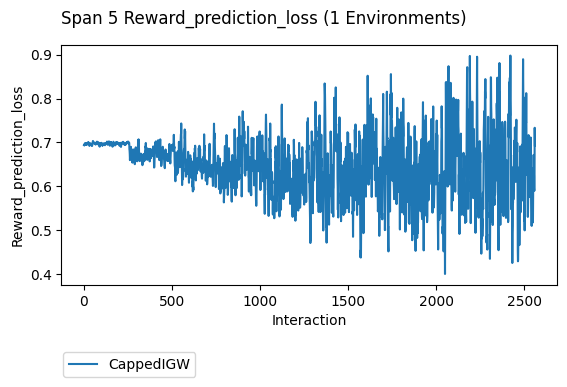

In [41]:
#result.plot_learners()
result.plot_learners(y='reward_prediction_loss',span=5)